In [1]:
# Step 1: Make function for Calzetti 2000 and Cardelli 1984 extinction curve
# Step 2: Plot both extimction curves as a function of wavelength
# Step 3: Make a function to calculate the the intrinsic flux from the observed flux
# Step 4: Plot BBRD sample intrinsic flux as function of number in data set

In [2]:
import numpy as np
import seaborn as sns
from astropy.table import Table
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Extinction curve function and Balmer Decrement functions:

In [3]:
def c00_k(wavelength, Rv=4.05):
    '''
    Calzetti extinction curve 2000 (Good for starburst like dust)
    Paremeters:
    
        wavelength: float, units of microns
        
        Rv: float, normilaztion of the extinction curve
    '''
    if np.logical_and(wavelength >= 0.63, wavelength <= 2.2):
        #k_lambda = 1.17 * (-1.857 + (1.040/rest_lam)) + 1.78 # Calzetti 2001 obscuration code
        k_lambda = 2.659 * (-1.857 + (1.040/wavelength)) + Rv # Calzetti 2000
        #print('k_lambda={}'.format(k_lambda))
    elif np.logical_and(wavelength >= 0.12, wavelength < 0.63):
        #k_lambda = 1.17 * (-2.156 + (1.509/rest_lam) - (0.198/rest_lam**2) + (0.011/rest_lam**3)) + 1.78 # Calzetti 2001 obscuration code
        k_lambda = 2.659 * (-2.156 + (1.509/wavelength) - (0.198/wavelength**2) + (0.011/wavelength**3)) + Rv
        #print('k_lambda={}'.format(k_lambda))
    else:
        print('Rest wavelength is not in range or not in Angstroms {}'.format(wavelength))
        
    return k_lambda


def c89_k(wavelength, Rv=3.1):
    '''
    Cardelli extinction curve 1989 (Good for MW like dust)
    Paremeters:
    
        wavelength: float, units of microns
        
        Rv: float, normilaztion of the extinction curve
    '''
    x = 1. / (wavelength)
    if ((x > 0.3) & (x < 1.1)):
        return 0.574 * (x ** 1.61) - 0.527 * (x ** 1.61) / Rv
    else:
        """
        Valid for 1.1 < x < 3.3 - all wavelengths in this code should be within this range.
        """
        y = x - 1.82
        
        a = 1. + 0.17699 * y - 0.50447 * (y ** 2) - 0.02427 * (y ** 3) + 0.72085 * (y ** 4) + 0.01979 * (
        y ** 5) - 0.77530 * (y ** 6) + 0.32999 * (y ** 7)
        
        b = 1.41338 * y + 2.28305 * (y ** 2) + 1.07233 * (y ** 3) - 5.38434 * (y ** 4) - 0.62251 * (
        y ** 5) + 5.30260 * (y ** 6) - 2.09002 * (y ** 7)
        return a + b / Rv
    
    
    
def balmer_dec(obs_haflux, obs_hbflux):
    '''
    Balmer decrement
    
    Paremeters:
        obs_haflux: float, observed halpha flux
        
        obs_hbflux: float, observed hbeta flux
    '''
    bdec = obs_haflux / obs_hbflux
    return bdec

# Testing extinction curve measurements

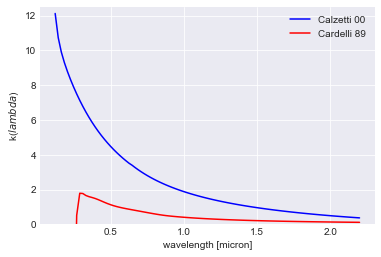

In [4]:
rest_lam_list = np.linspace(0.12, 2.2, 100)
rest_lam_list
c00_klist =[]
c89_klist = []
for wave in rest_lam_list:
    k00 = c00_k(wave, Rv=4.05)
    k89 = c89_k(wave, Rv=3.1)
    
    c00_klist.append(k00)
    c89_klist.append(k89)
    
plt.plot(rest_lam_list, c00_klist, color='blue', label='Calzetti 00')
plt.plot(rest_lam_list, c89_klist, color='red', label='Cardelli 89')
plt.ylim(0, 12.5)
plt.xlabel('wavelength [micron]')
plt.ylabel('k(${lambda}$)')
#plt.axvline(.3726)
#plt.axvline(.6731)
plt.legend()
plt.savefig('kcorr_compare.jpeg')

# Intrinsic flux function

In [5]:
 def c00_kcorr(obs_flux, obs_wavelength, bdec, Rv=4.05):
    '''
    Extinction correction using the Calztti extinction curve
    
    Paremeter:
        obs_flux: float, Obsereved flux [erg/cm^2/s]
        
        obs_wavelength: float, wavelength [micron]
        
        Rv: float, curve normilization
    '''
    
    # Observe flux
    print('Observe Flux = {} /1e-17erg/cm/s'.format(obs_flux/1e-17))
    
    # Observe extinction curve 
    obs_k = c00_k(obs_wavelength, Rv=Rv)
    print('k({} mircon) = {}'.format(obs_wavelength, obs_k))
    
    # Ha, Hb extinction curve
    k_Ha = c00_k(.6564, Rv)
    print('k({} mircon) = {}'.format(.6564, k_Ha))
    k_Hb = c00_k(.4864, Rv)
    print('k({} mircon) = {}'.format(.4864, k_Hb))
    
    # Optical depth tau
    tau = np.log(bdec / 2.86) # possibly np.log10
    print('Balmer optical depth={}'.format(tau))
    
    # color excess(gas) - Battisti et al 2017 eqn 2
    EBV_gas = (1.086 / (k_Hb - k_Ha)) * tau 
    EBV_star = EBV_gas * 0.44
    print('E(B-V)gas={}'.format(EBV_gas))
    print('E(B-V)star={}'.format(EBV_star))
    
    # Intrinsic flux [erg/cm^2/s]
    int_flux = obs_flux * 10**(0.4 * obs_k * EBV_star)
    print('intrinsic_flux = {} /1e-17erg/cm^2/s'.format(int_flux/1e-17))
    print('')
    
    return int_flux
    
    
def c89_kcorr(obs_flux, obs_wavelength, bdec, Rv=4.05):
    '''
    Extinction correction using the Calzetti extinction curve
    
    Paremeter:
        obs_flux: float, Obsereved flux [erg/cm^2/s]
        
        obs_wavelength: float, wavelength [micron]
        
        Rv: float, curve normilization
    '''
    # Observe flux
    print('Observe Flux = {} /1e-17/erg/cm^2/s'.format(obs_flux/1e-17))
    
    # Observe extinction curve 
    obs_k = c89_k(obs_wavelength, Rv=Rv)
    print('k({} mircon) = {}'.format(obs_wavelength, obs_k))
    
    # Ha, Hb extinction curve
    k_Ha = c89_k(.6564, Rv)
    print('k({} mircon) = {}'.format(.6564, k_Ha))
    k_Hb = c89_k(.4864, Rv)
    print('k({} mircon) = {}'.format(.4864, k_Hb))
    
    # Optical depth tau
    tau = np.log(bdec / 2.86) # possibly np.log10
    print('Balmer optical depth={}'.format(tau))
    
    # color excess(gas) - Battisti et al 2017 eqn 2
    EBV_gas = (1.086 / (k_Hb - k_Ha)) * tau 
    EBV_star = EBV_gas * 0.44
    print('E(B-V)gas={}'.format(EBV_gas))
    print('E(B-V)star={}'.format(EBV_star))
    
    # Intrinsic flux [erg/cm^2/s]
    int_flux = obs_flux * 10**(0.4 * obs_k * EBV_star)
    print('intrinsic_flux = {} /1e-17erg/cm^2/s'.format(int_flux/1e-17))
    print('')
    
    return int_flux

# Testing k_corr

In [6]:
c00_kcorr_flux = c00_kcorr(1.324e-16, .5007, 4.869, Rv=4.05)

Observe Flux = 13.239999999999998 /1e-17erg/cm/s
k(0.5007 mircon) = 4.463807117496362
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.5320669523688026
E(B-V)gas=0.4549389492488016
E(B-V)star=0.20017313766947273
intrinsic_flux = 30.150998269241672 /1e-17erg/cm^2/s



In [7]:
c89_kcorr_flux = c89_kcorr(1.324e-16, .5007, 4.869, Rv=3.1)

Observe Flux = 13.239999999999998 /1e-17/erg/cm^2/s
k(0.5007 mircon) = 1.1202240919861906
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.5320669523688026
E(B-V)gas=1.6713171153670778
E(B-V)star=0.7353795307615143
intrinsic_flux = 28.275085832168084 /1e-17erg/cm^2/s



In [8]:
diff_kcorr = c00_kcorr_flux - c89_kcorr_flux
diff_kcorr / 1e-17

1.8759124370735853

In [9]:
test_haflux = 4.656e-16
test_hbflux = 9.563e-17
test_bd = balmer_dec(test_haflux, test_hbflux)
test_bd

4.868765031893758

# Compare kcorr values for BBRD sample

In [10]:
bbrd = Table.read('/Users/mmckay/Desktop/research/BBRD_gal_sample/MM_bbrd126_sdss_table.txt', format='ascii')

# BBRD emission line fluxes
bbrd_Halpha_emline = bbrd['HalphaSDSSline']
bbrd_Hbeta_emline = bbrd['HbetaSDSSline']
bbrd_OIII5007_emline =  bbrd['OIII5007SDSSline']
bbrd_OIII4959_emline =  bbrd['OIII4959SDSSline']
bbrd_SII6716_emline = bbrd['S6717SDSSline']
bbrd_SII6731_emline = bbrd['S6731SDSSline']
bbrd_NII6583_emline = bbrd['N6583SDSS']
bbrd_OII3726_emline = bbrd['OII3726SDSSline']
bbrd_OII3729_emline = bbrd['OII3729SDSSline']



In [11]:
# Running k_corr on BBRD sample
c00_oiii_kcorr_int_flux_list = []
c89_oiii_kcorr_int_flux_list = []

c00_nii_kcorr_int_flux_list = []
c89_nii_kcorr_int_flux_list = []

c00_oii_kcorr_int_flux_list = []
c89_oii_kcorr_int_flux_list = []

c00_ha_kcorr_int_flux_list = []
c89_ha_kcorr_int_flux_list = []

c00_hb_kcorr_int_flux_list = []
c89_hb_kcorr_int_flux_list = []

bdec_list = []
for haflux, hbflux, oiii_flux, nii_flux, oii_flux in zip(bbrd_Halpha_emline, bbrd_Hbeta_emline, bbrd_OIII5007_emline, bbrd_NII6583_emline, bbrd_OII3729_emline):
    bdec = balmer_dec(haflux, hbflux)
    bdec_list.append(bdec)
    # OIII5007
    
    c00_intflux = c00_kcorr(oiii_flux, .5007, bdec, Rv=4.05)
    c89_intflux = c89_kcorr(oiii_flux, .5007, bdec, Rv=3.1)
    c00_oiii_kcorr_int_flux_list.append(c00_intflux)
    c89_oiii_kcorr_int_flux_list.append(c89_intflux)
    
    # NII6583
    c00_nii_kcorr_int_flux_list.append(c00_kcorr(nii_flux, .6583, bdec, Rv=4.05))
    c89_nii_kcorr_int_flux_list.append(c89_kcorr(nii_flux, .6583, bdec, Rv=3.1))
    
    # OII3729
    c00_oii_kcorr_int_flux_list.append(c00_kcorr(oii_flux, .3729, bdec, Rv=4.05))
    c89_oii_kcorr_int_flux_list.append(c89_kcorr(oii_flux, .3729, bdec, Rv=3.1))
    
    # haflux
    c00_ha_kcorr_int_flux_list.append(c00_kcorr(haflux, .6564, bdec, Rv=4.05))
    c89_ha_kcorr_int_flux_list.append(c89_kcorr(haflux, .6564, bdec, Rv=3.1))
    
    # hbflux
    c00_hb_kcorr_int_flux_list.append(c00_kcorr(hbflux, .4864, bdec, Rv=4.05))
    c89_hb_kcorr_int_flux_list.append(c89_kcorr(hbflux, .4864, bdec, Rv=3.1))


Observe Flux = 153.9548026688103 /1e-17erg/cm/s
k(0.5007 mircon) = 4.463807117496362
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.2267833836008597
E(B-V)gas=0.19390904430942527
E(B-V)star=0.08531997949614711
intrinsic_flux = 218.6422128269457 /1e-17erg/cm^2/s

Observe Flux = 153.9548026688103 /1e-17/erg/cm^2/s
k(0.5007 mircon) = 1.1202240919861906
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.2267833836008597
E(B-V)gas=0.7123670222431921
E(B-V)star=0.31344148978700453
intrinsic_flux = 212.73704612220143 /1e-17erg/cm^2/s

Observe Flux = 572.0419221590024 /1e-17erg/cm/s
k(0.6583 mircon) = 3.312996532128209
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.2267833836008597
E(B-V)gas=0.19390904430942527
E(B-V)star=0.08531997949614711
intrinsic_flux = 742.1535612312905 /1e-17erg/cm^2/s

Observe Flux = 572.0419221590024 /1e-17/erg/cm^2/s
k(

E(B-V)star=0.08178595149762487
intrinsic_flux = 212.66090943442808 /1e-17erg/cm^2/s

Observe Flux = 151.93470320499168 /1e-17/erg/cm^2/s
k(0.5007 mircon) = 1.1202240919861906
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.21738981796737003
E(B-V)gas=0.6828601585906399
E(B-V)star=0.30045846977988155
intrinsic_flux = 207.15208478908463 /1e-17erg/cm^2/s

Observe Flux = 945.194409665475 /1e-17erg/cm/s
k(0.6583 mircon) = 3.312996532128209
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.21738981796737003
E(B-V)gas=0.18587716249460196
E(B-V)star=0.08178595149762487
intrinsic_flux = 1213.1200309231717 /1e-17erg/cm^2/s

Observe Flux = 945.194409665475 /1e-17/erg/cm^2/s
k(0.6583 mircon) = 0.8146617331800533
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.21738981796737003
E(B-V)gas=0.6828601585906399
E(B-V)star=0.30045846977988155
intrinsic_flux

k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.48132588267064064
E(B-V)gas=1.5119303730388496
E(B-V)star=0.6652493641370938
intrinsic_flux = 722.6177480035982 /1e-17erg/cm^2/s

Observe Flux = 94.61157909296745 /1e-17erg/cm/s
k(0.4864 mircon) = 4.595270790842244
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.48132588267064064
E(B-V)gas=0.41155326474148557
E(B-V)star=0.18108343648625366
intrinsic_flux = 203.60819861635085 /1e-17erg/cm^2/s

Observe Flux = 94.61157909296745 /1e-17/erg/cm^2/s
k(0.4864 mircon) = 1.1633225281170798
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.48132588267064064
E(B-V)gas=1.5119303730388496
E(B-V)star=0.6652493641370938
intrinsic_flux = 192.97636425764438 /1e-17erg/cm^2/s

Observe Flux = 147.63331108015672 /1e-17erg/cm/s
k(0.5007 mircon) = 4.463807117496362
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optica


Observe Flux = 201.7484037835737 /1e-17erg/cm/s
k(0.3729 mircon) = 5.855181297058118
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.4235504072051131
E(B-V)gas=0.36215287634371485
E(B-V)star=0.15934726559123452
intrinsic_flux = 476.4452033339393 /1e-17erg/cm^2/s

Observe Flux = 201.7484037835737 /1e-17/erg/cm^2/s
k(0.3729 mircon) = 1.5386965321992638
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.4235504072051131
E(B-V)gas=1.3304473086160185
E(B-V)star=0.5853968157910481
intrinsic_flux = 462.4974339125425 /1e-17erg/cm^2/s

Observe Flux = 3339.6689683466357 /1e-17erg/cm/s
k(0.6564 mircon) = 3.3251559518586227
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.4235504072051131
E(B-V)gas=0.36215287634371485
E(B-V)star=0.15934726559123452
intrinsic_flux = 5440.580300039841 /1e-17erg/cm^2/s

Observe Flux = 3339.6689683466357 /1e-17/erg/cm^2/s


k(0.6564 mircon) = 3.3251559518586227
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.4544469042457058
E(B-V)gas=0.3885706416954952
E(B-V)star=0.1709710823460179
intrinsic_flux = 1231.5876512643235 /1e-17erg/cm^2/s

Observe Flux = 729.5635382170533 /1e-17/erg/cm^2/s
k(0.6564 mircon) = 0.8175923821384037
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.4544469042457058
E(B-V)gas=1.4274987117879974
E(B-V)star=0.6280994331867188
intrinsic_flux = 1170.778788723791 /1e-17erg/cm^2/s

Observe Flux = 161.9322330814342 /1e-17erg/cm/s
k(0.4864 mircon) = 4.595270790842244
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.4544469042457058
E(B-V)gas=0.3885706416954952
E(B-V)star=0.1709710823460179
intrinsic_flux = 333.8848191158843 /1e-17erg/cm^2/s

Observe Flux = 161.9322330814342 /1e-17/erg/cm^2/s
k(0.4864 mircon) = 1.1633225281170798
k(0.6564 mircon)

E(B-V)star=0.2211459137997901
intrinsic_flux = 706.563518898889 /1e-17erg/cm^2/s

Observe Flux = 359.82302647706314 /1e-17/erg/cm^2/s
k(0.6583 mircon) = 0.8146617331800533
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.5878132987981464
E(B-V)gas=1.8464263238825576
E(B-V)star=0.8124275825083254
intrinsic_flux = 661.9579724649938 /1e-17erg/cm^2/s

Observe Flux = 40.63616476953068 /1e-17erg/cm/s
k(0.3729 mircon) = 5.855181297058118
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.5878132987981464
E(B-V)gas=0.5026043495449775
E(B-V)star=0.2211459137997901
intrinsic_flux = 133.92217067873662 /1e-17erg/cm^2/s

Observe Flux = 40.63616476953068 /1e-17/erg/cm^2/s
k(0.3729 mircon) = 1.5386965321992638
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.5878132987981464
E(B-V)gas=1.8464263238825576
E(B-V)star=0.8124275825083254
intrinsic_flux = 128.51


Observe Flux = 82.36295328007823 /1e-17/erg/cm^2/s
k(0.3729 mircon) = 1.5386965321992638
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.4781821749552744
E(B-V)gas=1.5020554268746285
E(B-V)star=0.6609043878248365
intrinsic_flux = 210.1379187228023 /1e-17erg/cm^2/s

Observe Flux = 1220.3373924715102 /1e-17erg/cm/s
k(0.6564 mircon) = 3.3251559518586227
k(0.6564 mircon) = 3.3251559518586227
k(0.4864 mircon) = 4.595270790842244
Balmer optical depth=0.4781821749552744
E(B-V)gas=0.40886526640141435
E(B-V)star=0.17990071721662232
intrinsic_flux = 2117.186397006754 /1e-17erg/cm^2/s

Observe Flux = 1220.3373924715102 /1e-17/erg/cm^2/s
k(0.6564 mircon) = 0.8175923821384037
k(0.6564 mircon) = 0.8175923821384037
k(0.4864 mircon) = 1.1633225281170798
Balmer optical depth=0.4781821749552744
E(B-V)gas=1.5020554268746285
E(B-V)star=0.6609043878248365
intrinsic_flux = 2007.3360113494332 /1e-17erg/cm^2/s

Observe Flux = 264.50994528509153 /1e-17erg/cm/

In [51]:
print(np.round(np.median(bbrd_Halpha_emline) * 1e17, 3), np.round(np.std(bbrd_Halpha_emline) * 1e17))

1303.941 1293.0


In [67]:
print(np.median(bbrd_Halpha_emline/1e-17), np.std(bbrd_Halpha_emline/1e-17), -1*np.std(bbrd_Halpha_emline/1e-17))

1303.9409843215199 1293.0655160012623 -1293.0655160012623


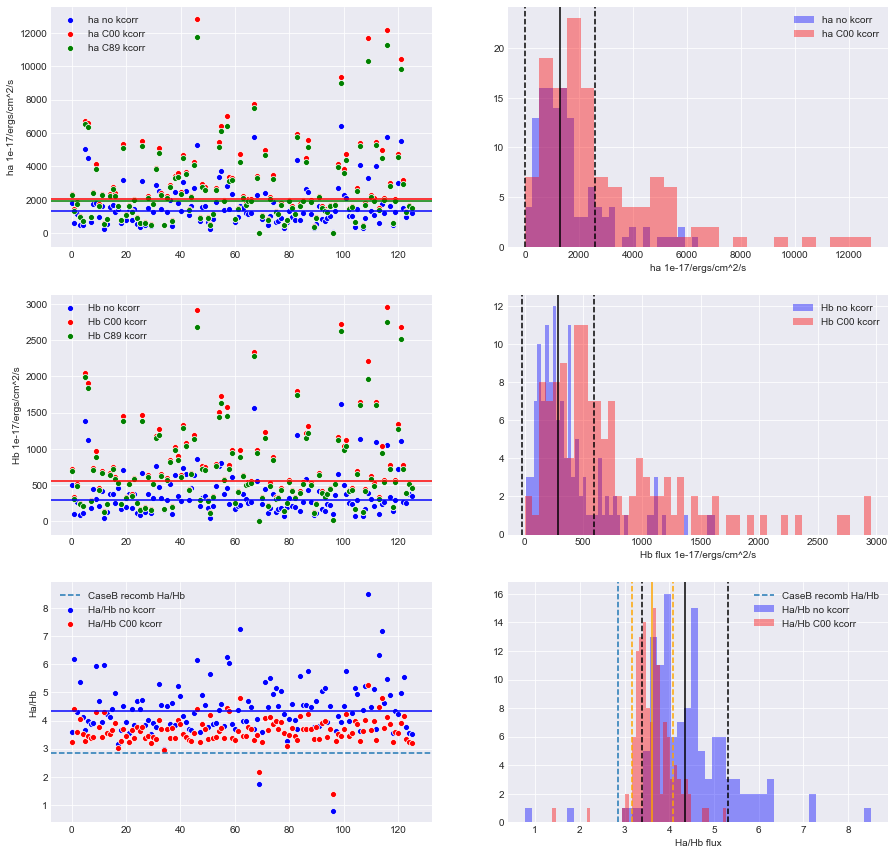

In [80]:
f, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize=(15, 15))
# Halpha
sns.scatterplot(np.arange(0, 126, 1), bbrd_Halpha_emline/1e-17, color='blue', 
                label='ha no kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_ha_kcorr_int_flux_list)/1e-17, 
                color='red', label='ha C00 kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_ha_kcorr_int_flux_list)/1e-17, 
                color='green', label='ha C89 kcorr', ax=ax1)
ax1.set_ylabel('ha 1e-17/ergs/cm^2/s')
med = np.median(bbrd_Halpha_emline/1e-17)
std = np.std(bbrd_Halpha_emline/1e-17)
ax1.axhline(np.median(bbrd_Halpha_emline/1e-17), color='blue')
ax1.axhline(np.median(np.array(c00_ha_kcorr_int_flux_list)/1e-17), color='red')
ax1.axhline(np.median(np.array(c89_ha_kcorr_int_flux_list)/1e-17), color='green')


sns.distplot(bbrd_Halpha_emline/1e-17, bins=25, color='blue', label='ha no kcorr', ax=ax2, kde=False)
sns.distplot(np.array(c00_ha_kcorr_int_flux_list)/1e-17, bins=25, color='red', label='ha C00 kcorr', ax=ax2, kde=False)
ax2.axvline(med, color='black', linestyle='-')
ax2.axvline(med + std, color='black', linestyle='--')
ax2.axvline(med - std, color='black', linestyle='--')
ax2.set_xlabel('ha 1e-17/ergs/cm^2/s')
ax2.legend()


# Hbeta
sns.scatterplot(np.arange(0, 126, 1), bbrd_Hbeta_emline/1e-17, color='blue', label='Hb no kcorr', ax=ax3)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_hb_kcorr_int_flux_list)/1e-17, color='red', label='Hb C00 kcorr', ax=ax3)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_hb_kcorr_int_flux_list)/1e-17, color='green', label='Hb C89 kcorr', ax=ax3)


ax3.set_ylabel('Hb 1e-17/ergs/cm^2/s')
ax3.axhline(np.median(bbrd_Hbeta_emline/1e-17), color='blue')
ax3.axhline(np.median(np.array(c00_hb_kcorr_int_flux_list)/1e-17), color='red')

sns.distplot(bbrd_Hbeta_emline/1e-17, bins=50, color='blue', label='Hb no kcorr', ax=ax4, kde=False)
sns.distplot(np.array(c00_hb_kcorr_int_flux_list)/1e-17, bins=50, color='red', label='Hb C00 kcorr', ax=ax4, kde=False)
med = np.median(bbrd_Hbeta_emline/1e-17)
std = np.std(bbrd_Hbeta_emline/1e-17)
ax4.axvline(med, color='black', linestyle='-')
ax4.axvline(med + std, color='black', linestyle='--')
ax4.axvline(med - std, color='black', linestyle='--')
ax4.set_xlabel('Hb flux 1e-17/ergs/cm^2/s')
ax4.legend()

# Halpha/Hbeta
C00_kcorr_bd = np.array(c00_ha_kcorr_int_flux_list) / np.array(c00_hb_kcorr_int_flux_list)
C89_kcorr_bd = np.array(c89_ha_kcorr_int_flux_list) / np.array(c89_hb_kcorr_int_flux_list)

sns.scatterplot(np.arange(0, 126, 1), bdec_list, color='blue', label='Ha/Hb no kcorr', ax=ax5)
sns.scatterplot(np.arange(0, 126, 1), C00_kcorr_bd, color='red', label='Ha/Hb C00 kcorr', ax=ax5)
#sns.scatterplot(np.arange(0, 126, 1), C89_kcorr_bd, color='green', label='Ha/Hb C89 kcorr', ax=ax5)
#sns.scatterplot(np.arange(0, 126, 1), np.array(c00_oii_kcorr_int_flux_list)/1e-17, color='red', label='OII C00 kcorr', ax=ax5)
#ax5.set_ylim(0,1000)
ax5.set_ylabel('Ha/Hb')
ax5.axhline(np.median(bdec_list), color='blue')
ax5.axhline(2.86, linestyle='--', label='CaseB recomb Ha/Hb')
#ax5.axhline(np.median(np.array(c00_oii_kcorr_int_flux_list)/1e-17), color='red')
ax5.legend()

sns.distplot(bdec_list, bins=50, color='blue', label='Ha/Hb no kcorr', ax=ax6, kde=False)
sns.distplot(C00_kcorr_bd, bins=50, color='red', label='Ha/Hb C00 kcorr', ax=ax6, kde=False)
#sns.distplot(C89_kcorr_bd, bins=50, color='green', label='Ha/Hb C89 kcorr', ax=ax6, kde=False)
ax6.axvline(2.86, linestyle='--', label='CaseB recomb Ha/Hb')
med = np.median(np.array(bdec_list))
std = np.std(np.array(bdec_list))
ax6.axvline(med, color='black', linestyle='-')
ax6.axvline(med + std, color='black', linestyle='--')
ax6.axvline(med - std, color='black', linestyle='--')

med = np.median(np.array(C00_kcorr_bd))
std = np.std(np.array(C00_kcorr_bd))
ax6.axvline(med, color='orange', linestyle='-')
ax6.axvline(med + std, color='orange', linestyle='--')
ax6.axvline(med - std, color='orange', linestyle='--')
ax6.set_xlabel('Ha/Hb flux')
ax6.legend()


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


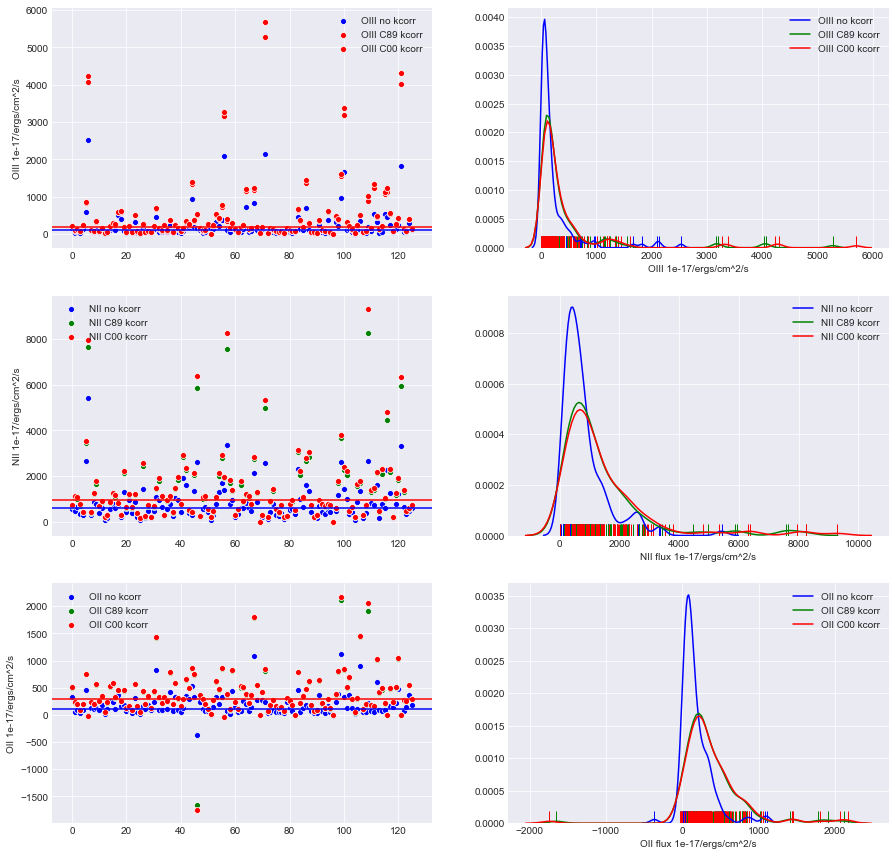

In [100]:
f, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3,2, figsize=(15, 15))
# OIII5007
sns.scatterplot(np.arange(0, 126, 1), bbrd_OIII5007_emline/1e-17, color='blue', label='OIII no kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_oiii_kcorr_int_flux_list)/1e-17, color='red', label='OIII C89 kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_oiii_kcorr_int_flux_list)/1e-17, color='red', label='OIII C00 kcorr', ax=ax1)
#ax1.set_ylim(0,1000)
ax1.set_ylabel('OIII 1e-17/ergs/cm^2/s')
ax1.axhline(np.median(bbrd_OIII5007_emline/1e-17), color='blue')
ax1.axhline(np.median(np.array(c00_oiii_kcorr_int_flux_list)/1e-17), color='red')

sns.distplot(bbrd_OIII5007_emline/1e-17, bins=50, color='blue', label='OIII no kcorr', ax=ax2, kde=True, rug=True, hist=False)
sns.distplot(np.array(c89_oiii_kcorr_int_flux_list)/1e-17, bins=50, color='green', label='OIII C89 kcorr', ax=ax2, kde=True, rug=True, hist=False)
sns.distplot(np.array(c00_oiii_kcorr_int_flux_list)/1e-17, bins=50, color='red', label='OIII C00 kcorr', ax=ax2, kde=True, rug=True, hist=False)
#ax2.set_xlim(0,1000)
ax2.set_xlabel('OIII 1e-17/ergs/cm^2/s')
plt.legend()


# NII6583
sns.scatterplot(np.arange(0, 126, 1), bbrd_NII6583_emline/1e-17, color='blue', label='NII no kcorr', ax=ax3)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_nii_kcorr_int_flux_list)/1e-17, color='green', label='NII C89 kcorr', ax=ax3)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_nii_kcorr_int_flux_list)/1e-17, color='red', label='NII C00 kcorr', ax=ax3)
#ax3.set_ylim(0,3000)
ax3.set_ylabel('NII 1e-17/ergs/cm^2/s')
ax3.axhline(np.median(bbrd_NII6583_emline/1e-17), color='blue')
ax3.axhline(np.median(np.array(c00_nii_kcorr_int_flux_list)/1e-17), color='red')

sns.distplot(bbrd_NII6583_emline/1e-17, bins=150, color='blue', label='NII no kcorr', ax=ax4, kde=True, rug=True, hist=False)
sns.distplot(np.array(c89_nii_kcorr_int_flux_list)/1e-17, bins=50, color='green', label='NII C89 kcorr', ax=ax4, kde=True, rug=True, hist=False)
sns.distplot(np.array(c00_nii_kcorr_int_flux_list)/1e-17, bins=50, color='red', label='NII C00 kcorr', ax=ax4, kde=True, rug=True, hist=False)
#ax4.set_xlim(0,3000)
ax4.set_xlabel('NII flux 1e-17/ergs/cm^2/s')
plt.legend()

# OII3729
sns.scatterplot(np.arange(0, 126, 1), bbrd_OII3729_emline/1e-17, color='blue', label='OII no kcorr', ax=ax5)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_oii_kcorr_int_flux_list)/1e-17, color='green', label='OII C89 kcorr', ax=ax5)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_oii_kcorr_int_flux_list)/1e-17, color='red', label='OII C00 kcorr', ax=ax5)
#ax5.set_ylim(0,1000)
ax5.set_ylabel('OII 1e-17/ergs/cm^2/s')
ax5.axhline(np.median(bbrd_OII3729_emline/1e-17), color='blue')
ax5.axhline(np.median(np.array(c00_oii_kcorr_int_flux_list)/1e-17), color='red')
plt.legend()

sns.distplot(bbrd_OII3729_emline/1e-17, bins=25, color='blue', label='OII no kcorr', ax=ax6, kde=True, rug=True, hist=False)
sns.distplot(np.array(c89_oii_kcorr_int_flux_list)/1e-17, bins=50, color='green', label='OII C89 kcorr', ax=ax6, kde=True, rug=True, hist=False)
sns.distplot(np.array(c00_oii_kcorr_int_flux_list)/1e-17, bins=50, color='red', label='OII C00 kcorr', ax=ax6, kde=True, rug=True, hist=False)
#ax6.set_xlim(0,1000)
ax6.set_xlabel('OII flux 1e-17/ergs/cm^2/s')
plt.legend()

Text(0.5, 0, '1e-17/ergs/cm^2/s')

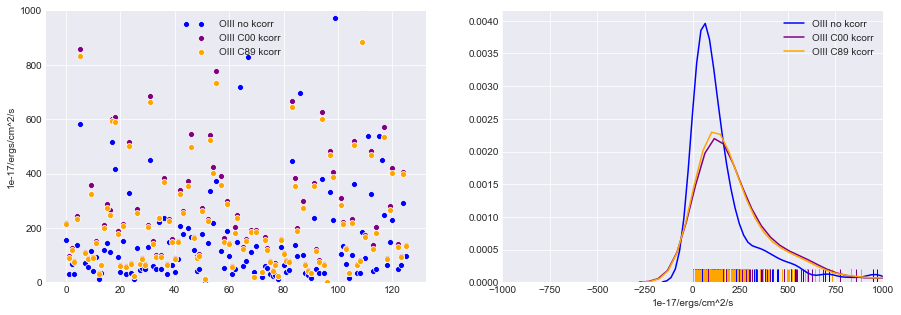

In [94]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.scatterplot(np.arange(0, 126, 1), bbrd_OIII5007_emline/1e-17, color='blue', label='OIII no kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_oiii_kcorr_int_flux_list)/1e-17, color='purple', label='OIII C00 kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_oiii_kcorr_int_flux_list)/1e-17, color='orange', label='OIII C89 kcorr', ax=ax1)

ax1.set_ylim(0,1000)
ax1.set_ylabel('1e-17/ergs/cm^2/s')

sns.distplot(bbrd_OIII5007_emline/1e-17, bins=150, color='blue', label='OIII no kcorr', ax=ax2, kde=True, rug=True, hist=False)
sns.distplot(np.array(c00_oiii_kcorr_int_flux_list)/1e-17, bins=150, color='purple', label='OIII C00 kcorr', ax=ax2, kde=True, rug=True, hist=False)
sns.distplot(np.array(c89_oiii_kcorr_int_flux_list)/1e-17, bins=150, color='orange', label='OIII C89 kcorr', ax=ax2, kde=True, rug=True, hist=False)
ax2.set_xlim(-1000,1000)
plt.legend()
ax2.set_xlabel('1e-17/ergs/cm^2/s')

Text(0.5, 0, '1e-17/ergs/cm^2/s')

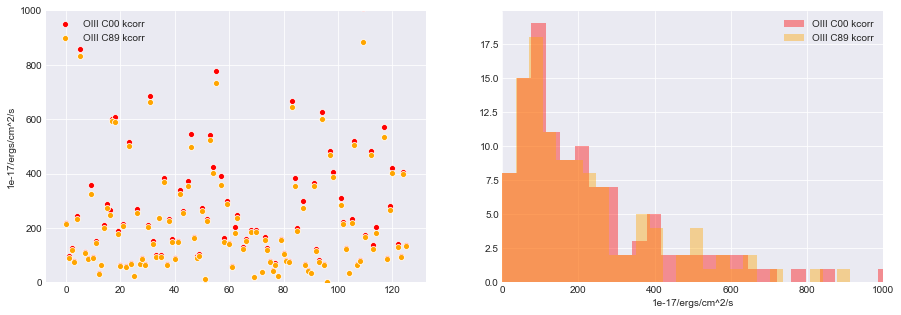

In [106]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.scatterplot(np.arange(0, 126, 1), np.array(c00_oiii_kcorr_int_flux_list)/1e-17, color='red', label='OIII C00 kcorr', ax=ax1)
sns.scatterplot(np.arange(0, 126, 1), np.array(c89_oiii_kcorr_int_flux_list)/1e-17, color='orange', label='OIII C89 kcorr', ax=ax1)
ax1.set_ylim(0,1000)
ax1.set_ylabel('1e-17/ergs/cm^2/s')

sns.distplot(np.array(c00_oiii_kcorr_int_flux_list)/1e-17, bins=150, color='red', label='OIII C00 kcorr', ax=ax2, kde=False)
sns.distplot(np.array(c89_oiii_kcorr_int_flux_list)/1e-17, bins=150, color='orange', label='OIII C89 kcorr', ax=ax2, kde=False)
ax2.set_xlim(0,1000)
plt.legend()
ax2.set_xlabel('1e-17/ergs/cm^2/s')

# Packaging for use on other notebooks - 

### Note: should make into a module for future use

In [ ]:
def c00_k(wavelength, Rv=4.05):
    '''
    Calzetti extinction curve 2000 (Good for starburst like dust)
    Paremeters:
    
        wavelength: float, units of microns
        
        Rv: float, normilaztion of the extinction curve
    '''
    if np.logical_and(wavelength >= 0.63, wavelength <= 2.2):
        #k_lambda = 1.17 * (-1.857 + (1.040/rest_lam)) + 1.78 # Calzetti 2001 obscuration code
        k_lambda = 2.659 * (-1.857 + (1.040/wavelength)) + Rv # Calzetti 2000
        #print('k_lambda={}'.format(k_lambda))
    elif np.logical_and(wavelength >= 0.12, wavelength < 0.63):
        #k_lambda = 1.17 * (-2.156 + (1.509/rest_lam) - (0.198/rest_lam**2) + (0.011/rest_lam**3)) + 1.78 # Calzetti 2001 obscuration code
        k_lambda = 2.659 * (-2.156 + (1.509/wavelength) - (0.198/wavelength**2) + (0.011/wavelength**3)) + Rv
        #print('k_lambda={}'.format(k_lambda))
    else:
        print('Rest wavelength is not in range or not in Angstroms {}'.format(wavelength))
        
    return k_lambda


def c89_k(wavelength, Rv=3.1):
    '''
    Cardelli extinction curve 1989 (Good for MW like dust)
    Paremeters:
    
        wavelength: float, units of microns
        
        Rv: float, normilaztion of the extinction curve
    '''
    x = 1. / (wavelength)
    if ((x > 0.3) & (x < 1.1)):
        return 0.574 * (x ** 1.61) - 0.527 * (x ** 1.61) / Rv
    else:
        """
        Valid for 1.1 < x < 3.3 - all wavelengths in this code should be within this range.
        """
        y = x - 1.82
        
        a = 1. + 0.17699 * y - 0.50447 * (y ** 2) - 0.02427 * (y ** 3) + 0.72085 * (y ** 4) + 0.01979 * (
        y ** 5) - 0.77530 * (y ** 6) + 0.32999 * (y ** 7)
        
        b = 1.41338 * y + 2.28305 * (y ** 2) + 1.07233 * (y ** 3) - 5.38434 * (y ** 4) - 0.62251 * (
        y ** 5) + 5.30260 * (y ** 6) - 2.09002 * (y ** 7)
        return a + b / Rv
    
    
    
def balmer_dec(obs_haflux, obs_hbflux):
    '''
    Balmer decrement
    
    Paremeters:
        obs_haflux: float, observed halpha flux
        
        obs_hbflux: float, observed hbeta flux
    '''
    bdec = obs_haflux / obs_hbflux
    return bdec


def c00_kcorr(obs_flux, obs_wavelength, bdec, Rv=4.05):
    '''
    Extinction correction using the Calzetti extinction curve
    
    Paremeter:
        obs_flux: float, Obsereved flux [erg/cm^2/s]
        
        obs_wavelength: float, wavelength [micron]
        
        Rv: float, curve normilization
    '''
    
    # Observe flux
    print('Observe Flux = {} /1e-17erg/cm/s'.format(obs_flux/1e-17))
    
    # Observe extinction curve 
    obs_k = c00_k(obs_wavelength, Rv=Rv)
    print('k({} mircon) = {}'.format(obs_wavelength, obs_k))
    
    # Ha, Hb extinction curve
    k_Ha = c00_k(.6564, Rv)
    print('k({} mircon) = {}'.format(.6564, k_Ha))
    k_Hb = c00_k(.4864, Rv)
    print('k({} mircon) = {}'.format(.4864, k_Hb))
    
    # Optical depth tau
    tau = np.log(bdec / 2.86) # possibly np.log10
    print('Balmer optical depth={}'.format(tau))
    
    # color excess(gas) - Battisti et al 2017 eqn 2
    EBV_gas = (1.086 / (k_Hb - k_Ha)) * tau 
    EBV_star = EBV_gas * 0.44
    print('E(B-V)gas={}'.format(EBV_gas))
    print('E(B-V)star={}'.format(EBV_star))
    
    # Intrinsic flux [erg/cm^2/s]
    int_flux = obs_flux * 10**(0.4 * obs_k * EBV_star)
    print('intrinsic_flux = {} /1e-17erg/cm^2/s'.format(int_flux/1e-17))
    print('')
    
    return int_flux
    
    
def c89_kcorr(obs_flux, obs_wavelength, bdec, Rv=4.05):
    '''
    Extinction correction using the Calzetti extinction curve
    
    Paremeter:
        obs_flux: float, Obsereved flux [erg/cm^2/s]
        
        obs_wavelength: float, wavelength [micron]
        
        Rv: float, curve normilization
    '''
    # Observe flux
    print('Observe Flux = {} /1e-17/erg/cm^2/s'.format(obs_flux/1e-17))
    
    # Observe extinction curve 
    obs_k = c89_k(obs_wavelength, Rv=Rv)
    print('k({} mircon) = {}'.format(obs_wavelength, obs_k))
    
    # Ha, Hb extinction curve
    k_Ha = c89_k(.6564, Rv)
    print('k({} mircon) = {}'.format(.6564, k_Ha))
    k_Hb = c89_k(.4864, Rv)
    print('k({} mircon) = {}'.format(.4864, k_Hb))
    
    # Optical depth tau
    tau = np.log(bdec / 2.86) # possibly np.log10
    print('Balmer optical depth={}'.format(tau))
    
    # color excess(gas) - Battisti et al 2017 eqn 2
    EBV_gas = (1.086 / (k_Hb - k_Ha)) * tau 
    EBV_star = EBV_gas * 0.44
    print('E(B-V)gas={}'.format(EBV_gas))
    print('E(B-V)star={}'.format(EBV_star))
    
    # Intrinsic flux [erg/cm^2/s]
    int_flux = obs_flux * 10**(0.4 * obs_k * EBV_star)
    print('intrinsic_flux = {} /1e-17erg/cm^2/s'.format(int_flux/1e-17))
    print('')
    
    return int_flux
